#Qiskit 71 -
3 server 3 vm

Riparto da Qiskit 51 che era SUCCESS
e cerco di modificare parametri

##Beginning settings

In [ ]:
try: INSTALLED
except NameError: INSTALLED = None

if INSTALLED!=1:
  !pip install Qiskit ipywidgets
  !pip install qiskit
  !pip install qiskit_optimization
  !pip install qiskit-optimization
  !pip install cplex
  !pip install ibm-quantum-widgets
  !pip install docplex
  INSTALLED=1

In [ ]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

In [ ]:
import time
from typing import List, Optional, Any
import numpy as np
import matplotlib.pyplot as plt

from docplex.mp.model import Model

from qiskit import BasicAer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CobylaOptimizer, MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization.translators import from_docplex_mp

from qiskit.utils.algorithm_globals import algorithm_globals
algorithm_globals.massive=True

# If CPLEX is installed, you can uncomment this line to import the CplexOptimizer.
# CPLEX can be used in this tutorial to solve the convex continuous problem,
# but also as a reference to solve the QUBO, or even the full problem.
#
# from qiskit.optimization.algorithms import CplexOptimizer

In [ ]:
# define COBYLA optimizer to handle convex continuous problems.
cobyla = CobylaOptimizer()

# define QAOA via the minimum eigen optimizer
qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=BasicAer.get_backend("statevector_simulator")))

# exact QUBO solver as classical benchmark
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())  # to solve QUBOs

# in case CPLEX is installed it can also be used for the convex problems, the QUBO,
# or as a benchmark for the full problem.
#
# cplex = CplexOptimizer()

##Problem definition

In [ ]:
# construct model using docplex
mdl = Model("ex51")

#server = M = 4 = i = i0, i1, i2, i3
#virtual machine = N = 6 = j = j0, j1, j2, j3, j4, j5
#all servers have the same idle and dynamic power consumption
#all servers have the same maximum cpu capacity

si0 = mdl.binary_var(name="si0")
si1 = mdl.binary_var(name="si1")
si2 = mdl.binary_var(name="si2")

vj0i0 = mdl.continuous_var(name="vj0i0")
vj1i0 = mdl.continuous_var(name="vj1i0")
vj2i0 = mdl.continuous_var(name="vj2i0")

vj0i1 = mdl.continuous_var(name="vj0i1")
vj1i1 = mdl.continuous_var(name="vj1i1")
vj2i1 = mdl.continuous_var(name="vj2i1")

vj0i2 = mdl.continuous_var(name="vj0i2")
vj1i2 = mdl.continuous_var(name="vj1i2")
vj2i2 = mdl.continuous_var(name="vj2i2")

pi = 1
pd = 1
pi0 = 2
pd0 = 2
pi1 = 2
pd1 = 2
pi2 = 3
pd2 = 3
ci0 = 40
ci1 = 30
ci2 = 30

uj0 = mdl.continuous_var(name="uj0")
uj1 = mdl.continuous_var(name="uj1")
uj2 = mdl.continuous_var(name="uj2")

sum0 = (vj0i0+vj1i0+vj2i0)
sum1 = (vj0i1+vj1i1+vj2i1)
sum2 = (vj0i2+vj1i2+vj2i2)

mdl.minimize(pi0*si0+pd0*(uj0*vj0i0+uj1*vj1i0+uj2*vj2i0)+pi1*si1+pd1*(uj0*vj0i1+uj1*vj1i1+uj2*vj2i1)+pi2*si2+pd2*(uj0*vj0i2+uj1*vj1i2+uj2*vj2i2))

mdl.add_constraint((vj0i0+vj1i0+vj2i0) >= ci0-5, "cons2")
mdl.add_constraint((vj0i1+vj1i1+vj2i1) >= ci1-5, "cons3")
mdl.add_constraint((vj0i2+vj1i2+vj2i2) >= ci2-5, "cons4")

mdl.add_constraint((vj0i0+vj1i0+vj2i0) >= 0, "cons5")
mdl.add_constraint((vj0i1+vj1i1+vj2i1) >= 0, "cons6")
mdl.add_constraint((vj0i2+vj1i2+vj2i2) >= 0, "cons7")

#mdl.add_constraint((vj0i0+vj1i0+vj2i0) <= ci0,"cons10")
#mdl.add_constraint((vj0i1+vj1i1+vj2i1) <= ci1, "cons11")
#mdl.add_constraint((vj0i2+vj1i2+vj2i2) <= ci2, "cons12")

mdl.add_constraint((si0) >= 1, "cons14")
mdl.add_constraint((si1) >= 1, "cons15")
mdl.add_constraint((si2) >= 1, "cons16")

mdl.add_constraint((vj0i0+vj0i1+vj0i2) <= ci0,"cons18")
mdl.add_constraint((vj1i0+vj1i1+vj1i2) <= ci1,"cons19")
mdl.add_constraint((vj2i0+vj2i1+vj2i2) <= ci2,"cons20")

mdl.add_constraint(uj0 >= 1,"cons21")
mdl.add_constraint(uj1 >= 1,"cons22")
mdl.add_constraint(uj2 >= 1,"cons23")

#mdl.add_constraint(vj0i0 >= -1,"cons32")
#mdl.add_constraint(vj0i1 >= -1,"cons24")
#mdl.add_constraint(vj0i2 >= -1,"cons25")
#mdl.add_constraint(vj1i0 >= -1,"cons26")
#mdl.add_constraint(vj1i1 >= -1,"cons27")
#mdl.add_constraint(vj1i2 >= -1,"cons28")
#mdl.add_constraint(vj2i0 >= -1,"cons29")
#mdl.add_constraint(vj2i1 >= -1,"cons30")
#mdl.add_constraint(vj2i2 >= -1,"cons31")

docplex.mp.LinearConstraint[cons23](uj2,GE,1)

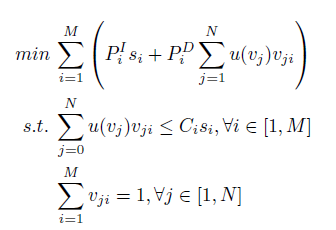

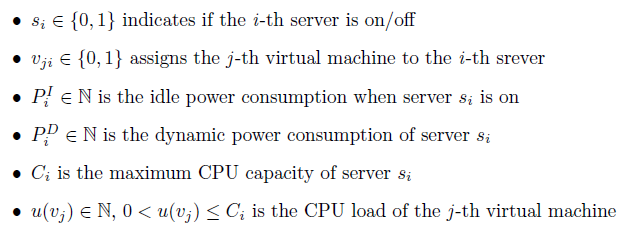

In [ ]:
# load quadratic program from docplex model
qp = from_docplex_mp(mdl)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: ex51

Minimize
 obj: 2 si0 + 2 si1 + 3 si2 + [ 4 vj0i0*uj0 + 4 vj1i0*uj1 + 4 vj2i0*uj2
      + 4 vj0i1*uj0 + 4 vj1i1*uj1 + 4 vj2i1*uj2 + 6 vj0i2*uj0 + 6 vj1i2*uj1
      + 6 vj2i2*uj2 ]/2
Subject To
 cons2: vj0i0 + vj1i0 + vj2i0 >= 35
 cons3: vj0i1 + vj1i1 + vj2i1 >= 25
 cons4: vj0i2 + vj1i2 + vj2i2 >= 25
 cons5: vj0i0 + vj1i0 + vj2i0 >= 0
 cons6: vj0i1 + vj1i1 + vj2i1 >= 0
 cons7: vj0i2 + vj1i2 + vj2i2 >= 0
 cons14: si0 >= 1
 cons15: si1 >= 1
 cons16: si2 >= 1
 cons18: vj0i0 + vj0i1 + vj0i2 <= 40
 cons19: vj1i0 + vj1i1 + vj1i2 <= 30
 cons20: vj2i0 + vj2i1 + vj2i2 <= 30
 cons21: uj0 >= 1
 cons22: uj1 >= 1
 cons23: uj2 >= 1

Bounds
 0 <= si0 <= 1
 0 <= si1 <= 1
 0 <= si2 <= 1

Binaries
 si0 si1 si2
End



##Classical solution

In [ ]:
admm_params = ADMMParameters(
                            rho_initial=1001,
                            beta=1000,
                            factor_c=900,
                            maxiter=100,
                            three_block=True, tol=1.e-6
                        )

In [ ]:
# define QUBO optimizer
qubo_optimizer = exact
# qubo_optimizer = cplex  # uncomment to use CPLEX instead

# define classical optimizer
convex_optimizer = cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(params=admm_params,
                     qubo_optimizer=qubo_optimizer,
                     continuous_optimizer=convex_optimizer,
                    )

In [ ]:
# run ADMM to solve problem
import time
t1 = time.perf_counter()

result = admm.solve(qp)

t2 = time.perf_counter()
print('time taken to run:',round(t2-t1),' seconds')
#%tb
#%timeit

time taken to run: 336  seconds


In [ ]:
print(result.prettyprint())

objective function value: 201.99999999999997
variable values: si0=1.0, si1=1.0, si2=1.0, vj0i0=12.150360813245983, vj1i0=11.68688452639013, vj2i0=11.162754660363886, vj0i1=8.380714178791246, vj1i1=8.94241503481362, vj2i1=7.676870786395134, vj0i2=8.874471401747094, vj1i2=8.036262049319268, vj2i2=8.089266548933635, uj0=1.0, uj1=1.0, uj2=1.0
status: SUCCESS


* objective function value: 201.99999999999997
* si0=1.0, si1=1.0, si2=1.0
* vj0i0=12.15, vj1i0=11.69, vj2i0=11.16
* vj0i1=8.38, vj1i1=8.94, vj2i1=7.68
* vj0i2=8.87, vj1i2=8.04, vj2i2=8.09
* uj0=1.0, uj1=1.0, uj2=1.0
* status: SUCCESS

In [ ]:
lvj0i0=29.55
lvj1i0=35.30
lvj2i0=30.15
lvj0i1=40.24
lvj1i1=44.98
lvj2i1=39.78
lvj0i2=29.52
lvj1i2=36.27
lvj2i2=29.21

In [ ]:
print("j0=",lvj0i0+lvj0i1+lvj0i2)
print("j1=",lvj1i0+lvj1i1+lvj1i2)
print("j2=",lvj2i0+lvj2i1+lvj2i2)
print("i0=",lvj0i0+lvj1i0+lvj2i0)
print("i1=",lvj0i1+lvj1i1+lvj2i1)
print("i2=",lvj0i2+lvj1i2+lvj2i2)

j0= 99.31
j1= 116.55000000000001
j2= 99.14000000000001
i0= 95.0
i1= 125.0
i2= 95.0


In [ ]:
print(f"vj0i0=15.833203823269944, vj1i0=15.833356482350474, vj2i0=15.83351528067469, vj3i0=15.833346959064396, vj4i0=15.83327016528088, vj5i0=15.833307289359617, vj0i1=20.981811860339693, vj1i1=21.431644805734642, vj2i1=20.673826629800644, vj3i1=20.673750927740297, vj4i1=20.67375718520671, vj5i1=20.673815533046607, vj0i2=15.833337325309735, vj1i2=15.833368241568234, vj2i2=15.83329609545665, vj3i2=15.833280092698791, vj4i2=15.833284821567016, vj5i2=15.833433423399574, vj0i3=10.863487940977873, vj1i3=10.838852457227105, vj2i3=10.838880490927862, vj3i3=10.916712504795234, vj4i3=10.917150104637637, vj5i3=10.624916501434289, uj0=3.043120757378878e-07, uj1=1.4923742233541295e-22, uj2=0.9998022337171757, uj3=0.9998691327097831, uj4=9.282309221937615e-05, uj5=5.651087477267203e-22")

vj0i0=15.833203823269944, vj1i0=15.833356482350474, vj2i0=15.83351528067469, vj3i0=15.833346959064396, vj4i0=15.83327016528088, vj5i0=15.833307289359617, vj0i1=20.981811860339693, vj1i1=21.431644805734642, vj2i1=20.673826629800644, vj3i1=20.673750927740297, vj4i1=20.67375718520671, vj5i1=20.673815533046607, vj0i2=15.833337325309735, vj1i2=15.833368241568234, vj2i2=15.83329609545665, vj3i2=15.833280092698791, vj4i2=15.833284821567016, vj5i2=15.833433423399574, vj0i3=10.863487940977873, vj1i3=10.838852457227105, vj2i3=10.838880490927862, vj3i3=10.916712504795234, vj4i3=10.917150104637637, vj5i3=10.624916501434289, uj0=3.043120757378878e-07, uj1=1.4923742233541295e-22, uj2=0.9998022337171757, uj3=0.9998691327097831, uj4=9.282309221937615e-05, uj5=5.651087477267203e-22


In [ ]:
vj0i0_sol=15.833203823269944
vj1i0_sol=15.833356482350474
vj2i0_sol=15.83351528067469
vj3i0_sol=15.833346959064396
vj4i0_sol=15.83327016528088
vj5i0_sol=15.833307289359617
vj0i1_sol=20.981811860339693
vj1i1_sol=21.431644805734642
vj2i1_sol=20.673826629800644
vj3i1_sol=20.673750927740297
vj4i1_sol=20.67375718520671
vj5i1_sol=20.673815533046607
vj0i2_sol=15.833337325309735
vj1i2_sol=15.833368241568234
vj2i2_sol=15.83329609545665
vj3i2_sol=15.833280092698791
vj4i2_sol=15.833284821567016
vj5i2_sol=15.833433423399574
vj0i3_sol=10.863487940977873
vj1i3_sol=10.838852457227105
vj2i3_sol=10.838880490927862
vj3i3_sol=10.916712504795234
vj4i3_sol=10.917150104637637
vj5i3_sol=10.624916501434289

vi0_sol=vj0i0_sol+vj1i0_sol+vj2i0_sol+vj3i0_sol+vj4i0_sol+vj5i0_sol
vi1_sol=vj0i1_sol+vj1i1_sol+vj2i1_sol+vj3i1_sol+vj4i1_sol+vj5i1_sol
vi2_sol=vj0i2_sol+vj1i2_sol+vj2i2_sol+vj3i2_sol+vj4i2_sol+vj5i2_sol
vi3_sol=vj0i3_sol+vj1i3_sol+vj2i2_sol+vj3i3_sol+vj4i3_sol+vj5i3_sol

vj0_sol=vj0i0_sol+vj0i1_sol+vj0i2_sol+vj0i3_sol
vj1_sol=vj1i0_sol+vj1i1_sol+vj1i2_sol+vj1i3_sol
vj2_sol=vj2i0_sol+vj2i1_sol+vj2i2_sol+vj2i3_sol
vj3_sol=vj3i0_sol+vj3i1_sol+vj3i2_sol+vj3i3_sol
vj4_sol=vj4i0_sol+vj4i1_sol+vj4i2_sol+vj4i3_sol
vj5_sol=vj5i0_sol+vj5i1_sol+vj5i2_sol+vj5i3_sol

print("vi0_sol = ",vi0_sol,"\nvi1_sol = ",vi1_sol,"\nvi2_sol = ",vi2_sol,"\nvi3_sol = ",vi3_sol)
print("vitot = ",vi0_sol+vi0_sol+vi1_sol+vi2_sol)
print("vj0_sol = ",vj0_sol,"\nvj1_sol = ",vj1_sol,"\nvj2_sol = ",vj2_sol,"\nvj3_sol = ",vj3_sol,"\nvj4_sol = ",vj4_sol,"\nvj5_sol = ",vj5_sol)
print("vjtot = ",vj0_sol+vj1_sol+vj2_sol+vj3_sol+vj4_sol+vj5_sol)

vi0_sol =  95.0 
vi1_sol =  125.1086069418686 
vi2_sol =  95.0 
vi3_sol =  69.99441560452878
vitot =  410.10860694186863
vj0_sol =  63.51184094989725 
vj1_sol =  63.93722198688046 
vj2_sol =  63.17951849685984 
vj3_sol =  63.25709048429872 
vj4_sol =  63.257462276692245 
vj5_sol =  62.965472747240085
vjtot =  380.1086069418686


In [ ]:
print("x={:}".format(result.x))
print("fval={:.7f}".format(result.fval))
print("x={:}".format(result.state.residuals))

x=[ 1.          1.          1.         12.15036081 11.68688453 11.16275466
  8.38071418  8.94241503  7.67687079  8.8744714   8.03626205  8.08926655
  1.          1.          1.        ]
fval=202.0000000
x=[0.8657318290272538, 0.4124659529766767, 0.18654032323266537, 0.07996225474913013, 0.03241725276321733, 0.012317277938125584, 0.0045772741586995215, 0.0014860534749967151, 0.0004957780119435229, 0.0001985128369581204, 0.00012165618210422409, 9.9999999999912e-05, 0.00012743849298640792, 0.0001742591251209343, 0.00015788395331679645, 0.00010000000000004978, 0.00014145957825497244, 0.00013022185900226821, 0.00012633970627731037, 0.0001508310001897061, 9.999999999981963e-05, 0.0001, 0.00019191746249049647, 0.00016679424475281651, 0.00018428006344634455, 0.00019944570662373083, 0.00019228435118152695, 0.0001256938350833129, 0.00014437316758929102, 0.00011362111043584522, 0.0001, 0.00010000000000000002, 0.0001, 0.0002523390659647132, 0.00019128207981455083, 0.00017076947357478123, 0.0001000

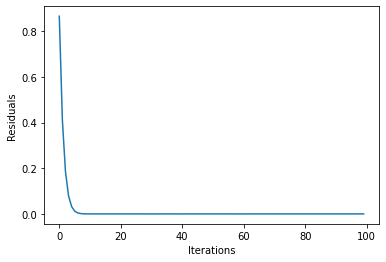

In [ ]:
plt.plot(result.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()

In [ ]:
lista = []
lista = result.state.residuals

In [ ]:
print(result)
print(result.state)
print(admm.get_compatibility_msg(qp))
admm.get_compatibility_msg(qp)

fval=201.99999999999997, si0=1.0, si1=1.0, si2=1.0, vj0i0=12.150360813245983, vj1i0=11.68688452639013, vj2i0=11.162754660363886, vj0i1=8.380714178791246, vj1i1=8.94241503481362, vj2i1=7.676870786395134, vj0i2=8.874471401747094, vj1i2=8.036262049319268, vj2i2=8.089266548933635, uj0=1.0, uj1=1.0, uj2=1.0, status=SUCCESS



''

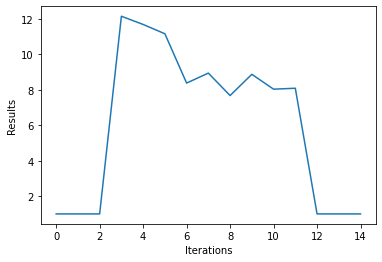

In [ ]:
plt.plot(result.x)
plt.xlabel("Iterations")
plt.ylabel("Results")
plt.show()

In [ ]:
#import matplotlib.pyplot as plt
#
#fig, ax = plt.subplots()
#
#f = [result.x]
#c = [40, 100, 30, 55]
#
#ax.bar(f, c,)
#
#ax.set_ylabel("Residuals")
#ax.set_title("Results")
#
#
#plt.show()

In [ ]:
result

<ADMMOptimizationResult: fval=201.99999999999997, si0=1.0, si1=1.0, si2=1.0, vj0i0=12.150360813245983, vj1i0=11.68688452639013, vj2i0=11.162754660363886, vj0i1=8.380714178791246, vj1i1=8.94241503481362, vj2i1=7.676870786395134, vj0i2=8.874471401747094, vj1i2=8.036262049319268, vj2i2=8.089266548933635, uj0=1.0, uj1=1.0, uj2=1.0, status=SUCCESS>

<qiskit_optimization.algorithms.admm_optimizer.ADMMState at 0x7f139d9c9a10>

##Quantum solution

In [ ]:
# define QUBO optimizer
qubo_optimizer = qaoa

# define classical optimizer
convex_optimizer = cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with quantum QUBO optimizer and classical convex optimizer
admm_q = ADMMOptimizer(
    params=admm_params, qubo_optimizer=qubo_optimizer, continuous_optimizer=convex_optimizer
)

In [ ]:
# run ADMM to solve problem
import time
t1 = time.perf_counter()

result_q = admm_q.solve(qp)

t2 = time.perf_counter()
print('time taken to run:',round(t2-t1),' seconds')
#%tb
#%timeit

time taken to run: 368  seconds


In [ ]:
print(result_q.prettyprint())

objective function value: 201.99999999999997
variable values: si0=1.0, si1=1.0, si2=1.0, vj0i0=12.150360813245983, vj1i0=11.68688452639013, vj2i0=11.162754660363886, vj0i1=8.380714178791246, vj1i1=8.94241503481362, vj2i1=7.676870786395134, vj0i2=8.874471401747094, vj1i2=8.036262049319268, vj2i2=8.089266548933635, uj0=1.0, uj1=1.0, uj2=1.0
status: SUCCESS


In [ ]:
vj0i0_solq=15.833203823269944
vj1i0_solq=15.833356482350474
vj2i0_solq=15.83351528067469
vj3i0_solq=15.833346959064396
vj4i0_solq=15.83327016528088
vj5i0_solq=15.833307289359617
vj0i1_solq=20.981811860339693
vj1i1_solq=21.431644805734642
vj2i1_solq=20.673826629800644
vj3i1_solq=20.673750927740297
vj4i1_solq=20.67375718520671
vj5i1_solq=20.673815533046607
vj0i2_solq=15.833337325309735
vj1i2_solq=15.833368241568234
vj2i2_solq=15.83329609545665
vj3i2_solq=15.833280092698791
vj4i2_solq=15.833284821567016
vj5i2_solq=15.833433423399574
vj0i3_solq=10.863487940977873
vj1i3_solq=10.838852457227105
vj2i3_solq=10.838880490927862
vj3i3_solq=10.916712504795234
vj4i3_solq=10.917150104637637
vj5i3_solq=10.624916501434289

vi0_solq=vj0i0_solq+vj1i0_solq+vj2i0_solq+vj3i0_solq+vj4i0_solq+vj5i0_solq
vi1_solq=vj0i1_solq+vj1i1_solq+vj2i1_solq+vj3i1_solq+vj4i1_solq+vj5i1_solq
vi2_solq=vj0i2_solq+vj1i2_solq+vj2i2_solq+vj3i2_solq+vj4i2_solq+vj5i2_solq
vi3_solq=vj0i3_solq+vj1i3_solq+vj2i2_solq+vj3i3_solq+vj4i3_solq+vj5i3_solq

vj0_solq=vj0i0_solq+vj0i1_solq+vj0i2_solq+vj0i3_solq
vj1_solq=vj1i0_solq+vj1i1_solq+vj1i2_solq+vj1i3_solq
vj2_solq=vj2i0_solq+vj2i1_solq+vj2i2_solq+vj2i3_solq
vj3_solq=vj3i0_solq+vj3i1_solq+vj3i2_solq+vj3i3_solq
vj4_solq=vj4i0_solq+vj4i1_solq+vj4i2_solq+vj4i3_solq
vj5_solq=vj5i0_solq+vj5i1_solq+vj5i2_solq+vj5i3_solq

print("vi0_sol = ",vi0_solq,"\nvi1_sol = ",vi1_solq,"\nvi2_sol = ",vi2_solq,"\nvi3_sol = ",vi3_solq)
print("vitot = ",vi0_solq+vi0_solq+vi1_solq+vi2_solq)
print("vj0_sol = ",vj0_solq,"\nvj1_sol = ",vj1_solq,"\nvj2_sol = ",vj2_solq,"\nvj3_sol = ",vj3_solq,"\nvj4_sol = ",vj4_solq,"\nvj5_sol = ",vj5_solq)
print("vjtot = ",vj0_solq+vj1_solq+vj2_solq+vj3_solq+vj4_solq+vj5_solq)

vi0_sol =  95.0 
vi1_sol =  125.1086069418686 
vi2_sol =  95.0 
vi3_sol =  69.99441560452878
vitot =  410.10860694186863
vj0_sol =  63.51184094989725 
vj1_sol =  63.93722198688046 
vj2_sol =  63.17951849685984 
vj3_sol =  63.25709048429872 
vj4_sol =  63.257462276692245 
vj5_sol =  62.965472747240085
vjtot =  380.1086069418686


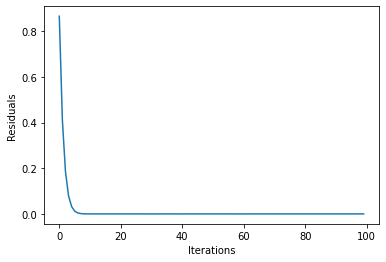

In [ ]:
plt.clf()
plt.plot(result_q.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()

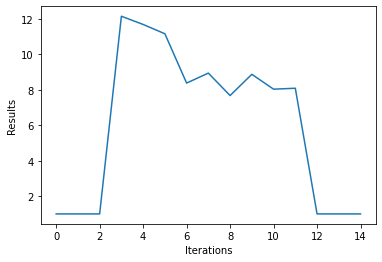

In [ ]:
plt.plot(result_q.x)
plt.xlabel("Iterations")
plt.ylabel("Results")
plt.show()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright